# STAT 201 Project Proposal (Group 16)
## Comparison of Break and Enter Crime in West Point Grey, Vancouver, BC pre- and post-COVID

## 1. Introduction

In late 2019, COVID-19 was first identified in Wuhan, China. It has since spread globally and was declared a pandemic by the World Health Organization (WHO) in March 2020. The virus is highly contagious. It spreads through respiratory droplets when an infected person talks, coughs, or sneezes.
Vancouver had a lockdown during COVID time. In March 18, 2020, the provincial government declared a state of emergency, and implemented a number of restrictions to help slow the spread of the virus, including lockdowns, closure of non-essential businesses, travel and social gathering restrictions. These measures aimed to encourage individuals to stay home as much as possible, minimizing their contact with others and reducing the risk of infection.
 
Past research has shown that the lockdown implemented in response to the COVID-19 pandemic has had various effects on crime rates. Some studies have found that overall crime rates have decreased during lockdowns, while others have found an increase in certain types of crime such as online fraud (Buil-Gil et al.; Shen et al.). Therefore, it is important to investigate the impact of lockdown measures on crime rates in specific areas and for specific types of crime. We are interested in determining if there was  difference in break and enter crime rates during the pandemic in comparison to pre-pandemic times. More specifically, we will focus on the West Point Grey area and analyze the period from March 2020 to February 2022 (during COVID) as well as March 2018 to February 2020 (pre-COVID). By comparing these time frames, we aim to better understand the impact of the COVID-19 lockdown on this particular type of crime.
The West Point Grey area of Vancouver is an interesting case study for investigating the impact of lockdown measures on crime rates. It is a residential area with a diverse population and a mix of single-family homes and multi-unit buildings. The pandemic may have affected the behavior of residents differently in this area compared to other parts of the city, leading to different patterns of criminal activity.

## 2. Methods and Results

We begin by loading the necessary R libraries for data wrangling and statistical inference.

In [2]:
library(tidyverse)
library(broom)
library(infer)
library(zoo)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




Next, we read the data from CSV files downloaded from the Vancouver Police Department (https://geodash.vpd.ca/opendata/) for the years 2018-2022 in the neighbourhood West Point Grey. This data is combined into a single data frame, cleaned, and classified into pre- and post-COVID crimes (Table 1).

In [3]:
# Read CSV files for 2018-2022
west_point_grey_2018 <- read_csv("https://raw.githubusercontent.com/willis-cao/stat201-project-group16/main/crimedata_csv_West%20Point%20Grey_2018.csv", show_col_types = FALSE)
west_point_grey_2019 <- read_csv("https://raw.githubusercontent.com/willis-cao/stat201-project-group16/main/crimedata_csv_West%20Point%20Grey_2019.csv", show_col_types = FALSE)
west_point_grey_2020 <- read_csv("https://raw.githubusercontent.com/willis-cao/stat201-project-group16/main/crimedata_csv_West%20Point%20Grey_2020.csv", show_col_types = FALSE)
west_point_grey_2021 <- read_csv("https://raw.githubusercontent.com/willis-cao/stat201-project-group16/main/crimedata_csv_West%20Point%20Grey_2021.csv", show_col_types = FALSE)
west_point_grey_2022 <- read_csv("https://raw.githubusercontent.com/willis-cao/stat201-project-group16/main/crimedata_csv_West%20Point%20Grey_2022.csv", show_col_types = FALSE)

# Bind all CSV files into a single data frame, 
# select variables of interest (TYPE, YEAR, MONTH),
# filter and classify crimes as pre- and post-COVID
wpg <- rbind(west_point_grey_2018, 
             west_point_grey_2019,
             west_point_grey_2020,
             west_point_grey_2021,
             west_point_grey_2022) |>
    select(TYPE, YEAR, MONTH) |>
    filter((YEAR == 2018 & MONTH > 2) | YEAR == 2019 | YEAR == 2020 | YEAR == 2021 | (YEAR == 2022 & MONTH < 3)) |>
    mutate(PERIOD = case_when(((YEAR == 2018 & MONTH > 2) | YEAR == 2019 | (YEAR == 2020 & MONTH < 3)) ~ 'pre',
                              ((YEAR == 2020 & MONTH > 2) | YEAR == 2021 | (YEAR == 2022 & MONTH < 3)) ~ 'post')) |>
    mutate(TYPE = as.factor(TYPE),
           PERIOD = as.factor(PERIOD))

head(wpg)

TYPE,YEAR,MONTH,PERIOD
<fct>,<dbl>,<dbl>,<fct>
Break and Enter Commercial,2018,5,pre
Break and Enter Commercial,2018,5,pre
Break and Enter Commercial,2018,9,pre
Break and Enter Commercial,2018,11,pre
Break and Enter Commercial,2018,9,pre
Break and Enter Commercial,2018,12,pre


*(Table 1. Crimes in West Point Grey)*

Next, visualize the data to obtain a better idea of trends and patterns and whether they provide any insight into our question. Breaking down the data month-by-month in the form of a barplot, we see that there is a spike in B&E immediately following COVID restrictions (March 2020, represented by the vertical black line) (Figure 1).

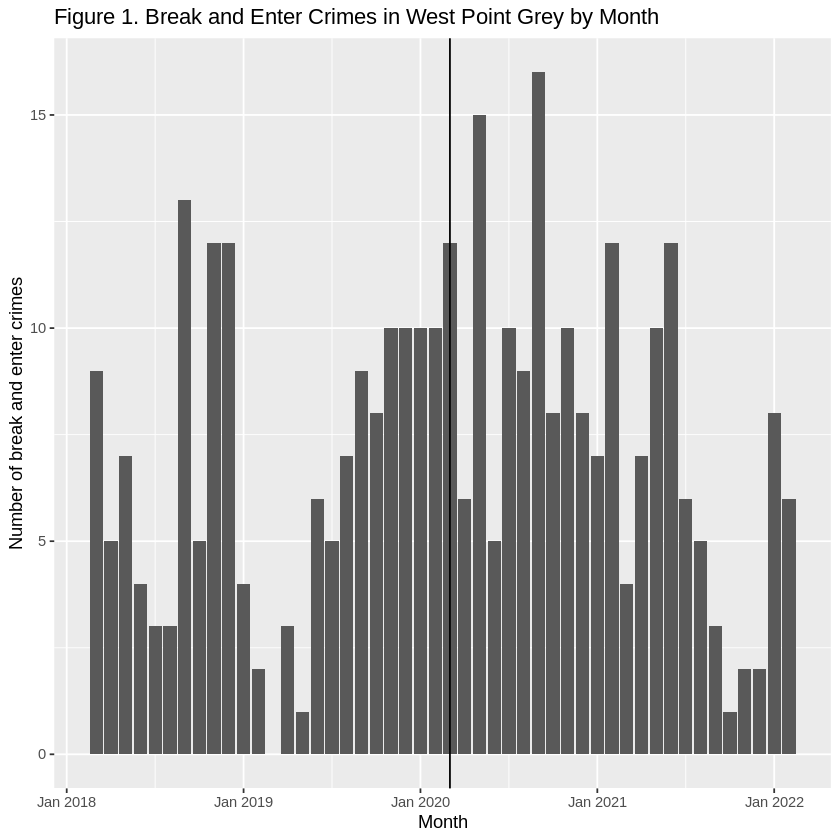

In [4]:
line_plot <- wpg |>
    filter(TYPE == "Break and Enter Commercial" | TYPE == "Break and Enter Residential/Other") |>
    mutate(YEARMON = as.yearmon(paste(YEAR, MONTH), "%Y %m")) |> # Convert YEAR and MONTH columns to date
    ggplot() +
    geom_bar(aes(x = YEARMON)) +
    geom_vline(xintercept = as.yearmon(paste(2020, 03), "%Y %m")) + # Vertical line at March 2020
    labs(title = "Figure 1. Break and Enter Crimes in West Point Grey by Month",
         x = "Month", 
         y = "Number of break and enter crimes")

line_plot

Next, we calculate summary statistics for the proportion of B&E (out of all crimes) across both time periods (Table 2). This enables us to gain a quantitative perspective on the bar plot shown above.

In [5]:
summary_tibble <- wpg |>
    group_by(PERIOD) |> # Group by pre- or post-COVID
    summarize(n_break = sum(TYPE == "Break and Enter Commercial" | TYPE == "Break and Enter Residential/Other"),
              n_total = n()) |> # Count the total number of B&E crimes in each group
    mutate(prop_break = n_break / n_total) # Calculate the proportion of B&E crimes out of all crimes in each group

summary_tibble

PERIOD,n_break,n_total,prop_break
<fct>,<int>,<int>,<dbl>
post,184,780,0.2358974
pre,158,882,0.1791383


*(Table 2: Summary table of counts and proportions of break and enter crime vs. total crime)*

We see that although there was a decrease in total crime post-COVID (780 vs 882 total crimes) but an increase in B&E crimes (184 vs 158). The proportion of B&E crime is thusly higher post-COVID (0.236 vs 0.179). A visual representation of the data is below, in the form of a stacked barplot (Figure 2). But first, we will refactor crime type into two categories: "Break and Enter" and "Other", which will enable us to do further analyses on the data which require binary categories.

In [6]:
# Factor TYPE into binary categories "Break and Enter" and "Other"
wpg_binary <- wpg |>
    mutate(TYPE = case_when(((TYPE != "Break and Enter Commercial") & (TYPE != "Break and Enter Residential/Other")) ~ "Other",
                           ((TYPE == "Break and Enter Commercial") | (TYPE == "Break and Enter Residential/Other")) ~ "Break and Enter"))

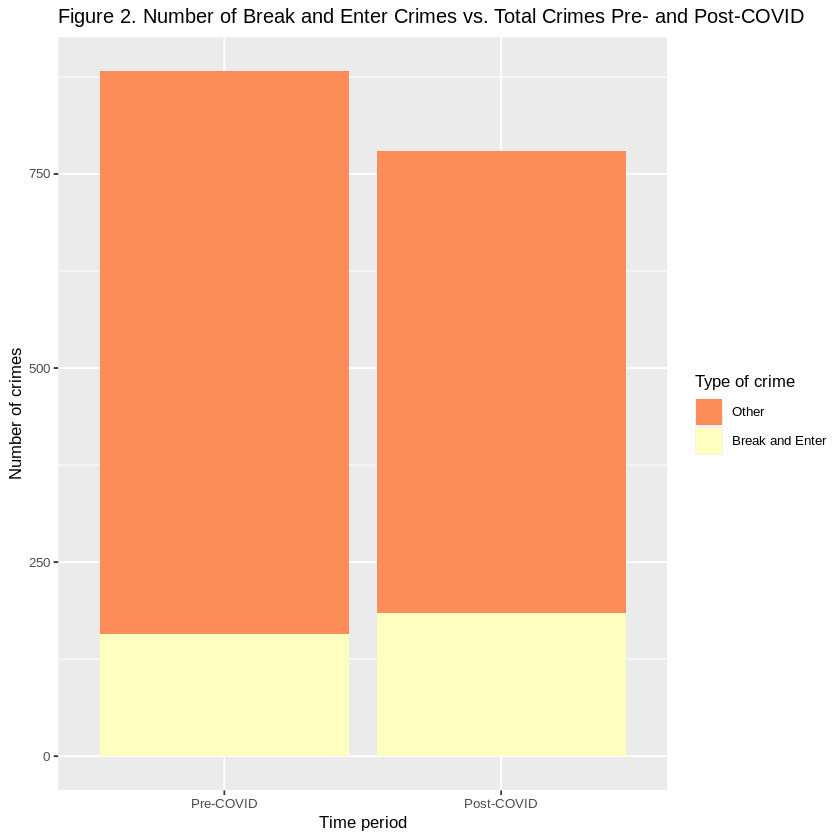

In [7]:
stacked_barplot <- wpg_binary |>
    ggplot() +
    geom_bar(aes(x = factor(PERIOD, levels = c("pre", "post")), fill = factor(TYPE, levels = c("Other", "Break and Enter")))) +
    scale_x_discrete(labels = c("pre" = "Pre-COVID", "post" = "Post-COVID")) +
    labs(title = "Figure 2. Number of Break and Enter Crimes vs. Total Crimes Pre- and Post-COVID", 
         x = "Time period", 
         y = "Number of crimes", 
         fill = "Type of crime") +
    theme(text = element_text(size = 10)) +
    scale_fill_brewer(palette = "Spectral")

stacked_barplot

Once again, we observe that the total number of crimes decreased post-COVID, but the number of B&E increased. Is this difference significant?

To answer this question, we will use two strategies concurrently which should produce similar results, bootstrapping and asymptotics. First, we will perform bootstrapping to create a distribution of differences in proportions, and generate a 95% confidence interval from this distribution. We will then assess whether this confidence interval suggests the B&E crime proportion is truly different pre- and post-COVID.

Setting `type = "bootstrap"` in `generate()`.



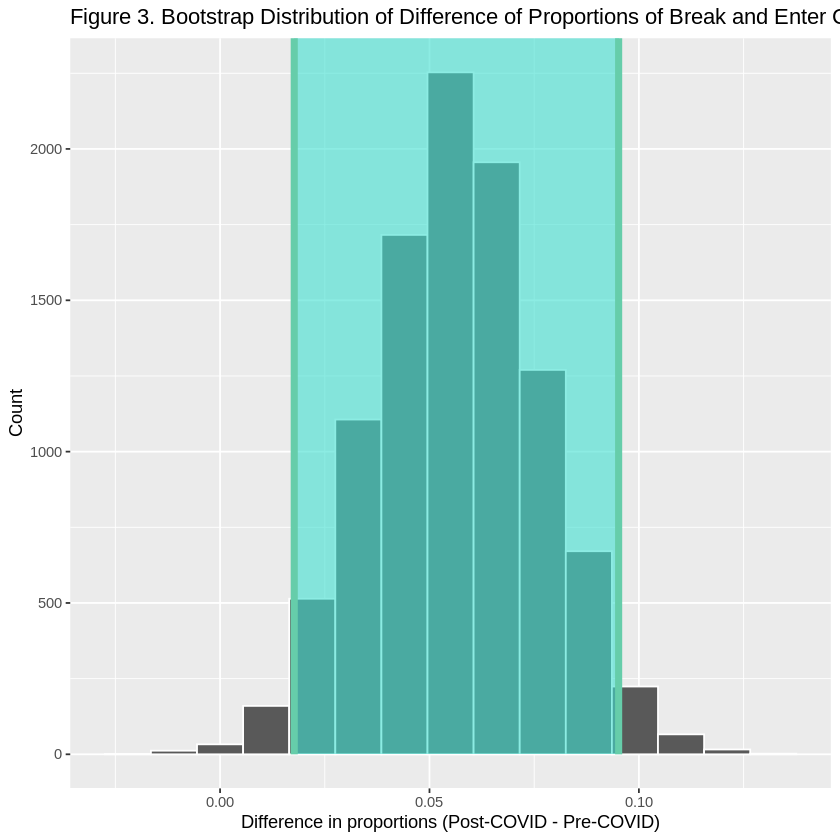

In [8]:
set.seed(2023)

# Set bootstrap repetitions
bootstrap_reps <- 10000

# Use the infer package to generate a bootstrap distribution of differences in proportions (post-COVID - pre-COVID)
diff_in_props_bootstrap <- wpg_binary |>
    specify(TYPE ~ PERIOD, 
            success = "Break and Enter") |>
    generate(reps = bootstrap_reps) |>
    calculate(stat = "diff in props", order = c("post", "pre"))

# Use the infer package to generate a 95% confidence interval using the percentile method
diff_in_props_ci <- diff_in_props_bootstrap |>
    get_confidence_interval(level = 0.95, type = "percentile")

# Visualize the confidence interval overlaid on the bootstrap distribution
diff_in_props_bootstrap_dist <- diff_in_props_bootstrap |>
    visualize() +
    shade_confidence_interval(diff_in_props_ci) +
    labs(title = "Figure 3. Bootstrap Distribution of Difference of Proportions of Break and Enter Crimes Pre- and Post-COVID",
         x = "Difference in proportions (Post-COVID - Pre-COVID)",
         y = "Count")

diff_in_props_bootstrap_dist

In [9]:
# Display the confidence interval
diff_in_props_ci

lower_ci,upper_ci
<dbl>,<dbl>
0.01770715,0.09516434


*(Table 3. 95% confidence interval, bootstrapping (reps = 10000), percentile method)*

Using bootstrapping (Figure 3), we estimate the sampling distribution of the original population, which we would not be able to obtain unless we took a very large number of samples, each with multiple observations. The confidence interval (Table 3) tells us that 95% of the time, we can expect the true difference in proportions to lie between 0.0177 and 0.0952. In other words, it is highly likely that the two groups differ in proportion.

Next, we will determine the odds that, supposed the two proportions are equal, that we could observe the difference in proportions that we do. In other words, given that our null hypothesis is true, what is the probability that such a difference in proportion occurs by random chance? We will determine this using asymptotics.

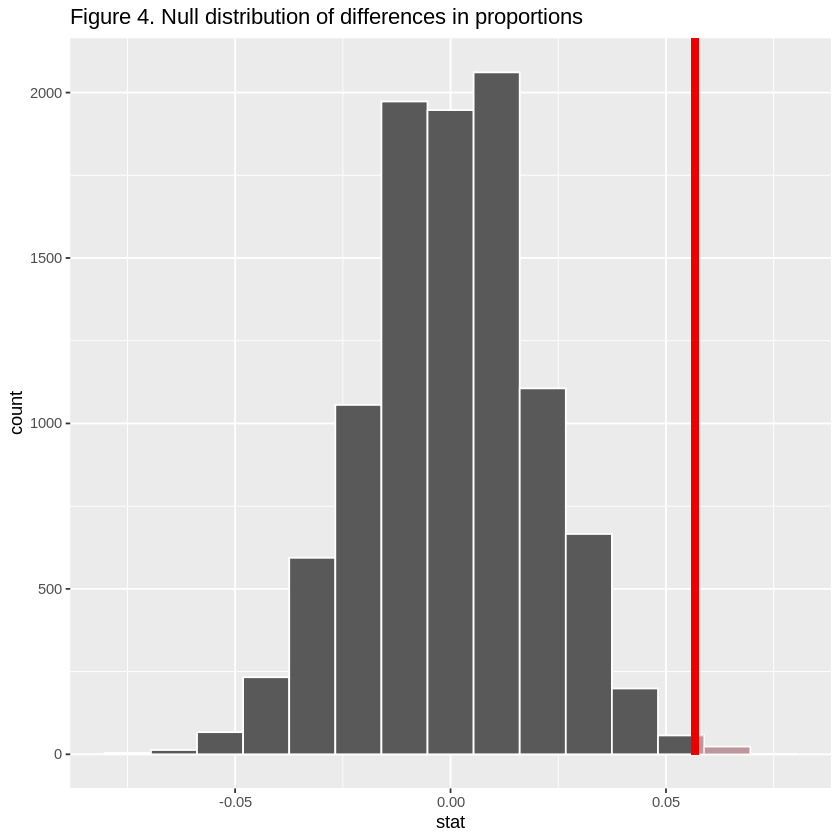

In [10]:
# Generate a null distribution using the infer package
null_distribution <- wpg_binary |>
    specify(TYPE ~ PERIOD, 
            success = "Break and Enter") |>
    hypothesize(null = "independence") |>
    generate(reps = 10000, type = "permute") |>
    calculate(stat = "diff in props", order = c("post", "pre"))

# Calculate the observed test statistic--the difference in proportions of our samples
diff_in_props <- wpg_binary |>
    specify(TYPE ~ PERIOD, 
            success = "Break and Enter") |>
    calculate(stat = "diff in props", order = c("post", "pre"))

# Shade the p-value, or the area of the null distribution to the right of our observed test statistic
diff_in_props_shaded <- null_distribution |>
    visualize() +
    shade_p_value(obs_stat = diff_in_props, direction = "right") +
    ggtitle("Figure 4. Null distribution of differences in proportions")

diff_in_props_shaded

Generating the null distribution above (Figure 4) allows us to see what the distribution of differences in proportions would look like if the null hypothesis were true--that is, if the two proportions were equal. Notice that the centre of the distribution is approximately 0. The red line is the observed test statistic--the difference in proportions that we calculated from our sample. The area to the right of this red line, lightly shaded in red, is the probability that such a difference (or greater) could be observed if the null hypothesis were true. Such a probability is extremely low, which suggests that the two proportions might be different after all!

The null distribution provides a good visualization of what we will do next, which is a z-test of two independent proportions. This calculates the 95% confidence interval and p-value, assuming that the data is roughly normal.

In [11]:
# Z-test for two independent proportions
prop_test_z = tidy(prop.test(
    x = c(184, 158), # A column vector containing the number of B&E crimes post- and pre-COVID, respectively
    n = c(780, 882), # A column vector containing the total number of crimes post- and pre-COVID, respectively
    alternative = "two.sided",
    correct = FALSE))

prop_test_z

estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
0.2358974,0.1791383,8.159535,0.004283536,1,0.01766727,0.09585096,2-sample test for equality of proportions without continuity correction,two.sided


*(Table 4: Z-test for two independent proportions)*

First, we observe the p-value of 0.00428, which is significantly lower than an alpha = 0.05 at the 95% significance level. This p-value can be interpreted as a 0.428% chance that the observed difference in proportions could take place from a random sample if the population proportions were equal. Thus, we can say that at alpha = 0.05, we reject the null hypothesis--there is statistical evidence that these two proportions are indeed different!

As a point of comparison, observe that the z-test also gives us a 95% confidence interval of (0.0177, 0.959). This is very, very close to that given from bootstrapping, which was (0.0177, 0.952). As we can see, both methods provide very similar results, and in this case are both appropriate for answering the research question. Bootstrapping can be more reliable when the computation is not expensive to do so, however, as it does not rely on the data following a normal distribution *N(0, 1)* as is required for a z-test of two independent proportions. A z-test is a computationally efficient way of estimating the same parameters, but is not as flexible as bootstrapping in general.

## 3. Discussion

The results from the previous section show that B&E crimes have a higher proportion of the total number of crimes post-COVID compared to pre-COVID (We will continue to refer to this result as the difference in proportion) , despite the fact that the total crime decreased post-COVID. This difference in proportion obtained through the bootstrap method and asymptotic theory is statistically significant. We have successfully rejected the null hypothesis through both methods.

To test the hypothesis, we first used the method of bootstrapping. The result from the sampling distribution of the difference in proportion and its 95% confidence interval is visualized in Figure 3. We can see from the histogram that the difference in proportion is centered around 0.05, indicating that there is a difference in the proportion of B&E crimes pre and post-COVID. This result is consistent with our preliminary analysis displayed in Figure 2 and the summary table before it. The majority of the difference in proportion falls within the shaded 95% confidence interval area, and the interval does not contain 0. This result suggests that we can be 95% confident that the true difference in proportion lies within 0.0177 and 0.0952 and that the difference is statistically significant and different from 0. Overall, the histogram demonstrates strong evidence for rejecting the null hypothesis that the difference in proportion pre and post-COVID is the same and is in favor of the alternative hypothesis that there is a difference in B&E in the West Point Grey area post-COVID compared to pre-COVID.

Secondly, under the assumption of asymptotic theory (specifically applying LLN), we obtained the same conclusion of rejecting the null hypothesis using different methods. We first used the prop_test command in the prop.test package in R to perform a proportion test using the p-value approach. As displayed in the prop_test result table, the test statistic of 8.159535 measures the difference between the observed difference in proportion and the difference in proportion under the null hypothesis. The p-value of 0.004283536 is extremely small, suggesting that if we assume the null is true, the likelihood of obtaining our observed test statistic is very low, which further suggests that we can reject the null hypothesis at the alpha = 0.05 significance level. The confidence interval indicates that the true difference in proportion lies within 0.01766727 to 0.09585096, and the fact that it does not contain 0 is further evidence that we can reject the null hypothesis (difference in proportion = 0). The second half of the code uses the inter package to generate the null distribution of the difference in proportion by performing a permutation test. We also calculated the observed difference in proportion from the original data to display as the red line when we visualize the null distribution. In the graph below, we can see that the null distribution is far away from our observed test statistic (difference in proportion), which is far from 0 and the rest of the null distribution, and the p-value is very small. As concluded above, this displays evidence that suggests we should reject the null hypothesis.

The outcome of our hypothesis test aligned with our preliminary result, that there is a difference in the proportions of Break and Enter crimes pre- and post-COVID in the Point gray area. We used hypothesis testing to ensure that this difference is statistically significant, different from 0, and not a coincidence of our sample but is generalizable to the population.  We further reduced the uncertainty around the estimate through the use of confidence intervals and p-values and arrived at the same conclusion through the use of multiple different statistical methods. 

The findings in this report could inform future research and perhaps raise causal questions, such as: Why did B&E become more frequent during COVID years when compared to other crimes? How can we reduce B&E by reducing “lockdown-like” conditions? How did crimes that are similar in nature to B&E change during the COVID era, and what does that reflect about the impact of COVID on particular groups? Our findings could serve as concrete work for criminal studies and social studies that can help reduce B&E-type crimes, crimes overall, and analyze COVID-related societal impacts.

## 4. References

VPD OPEN DATA. https://geodash.vpd.ca/opendata/. Last accessed Mar 18, 2023.

Buil-Gil, David, et al. “Offline Crime Bounces Back to Pre-Covid Levels, Cyber Stays High: Interrupted Time-Series Analysis in Northern Ireland.” Crime Science, vol. 10, no. 1, 2021, https://doi.org/10.1186/s40163-021-00162-9.

Shen, Yichen, et al. “COVID-19's Lockdown and Crime Victimization: The State of Emergency under the Abe Administration.” Asian Economic Policy Review, vol. 16, no. 2, 2021, pp. 327–348., https://doi.org/10.1111/aepr.12339. 